In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from sklearn.preprocessing import LabelEncoder

> 이 코드는 depth=1인 Decision Tree를 이용해서 optimal threshold를 구한다.

# 동양인 데이터

step1) 데이터 폴더(identity)를 5개로 나누기 - `idendities1~5`<br>
step2) 각각의 idendities 별로 `positive`, `negative` 구해서 1000개씩 뽑기 <br>
step3) 1000개씩 뽑은 positive + negative = `df1~5` 생성<br>

# Data set

In [ ]:
%%time
import os
data_path = '/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/'
ids = os.listdir(data_path)

idendities = {}
for id in ids:
    idendities[id] = os.listdir(data_path + id)

CPU times: user 30.7 ms, sys: 47.1 ms, total: 77.8 ms
Wall time: 48.3 s


In [ ]:
len(idendities) 

320

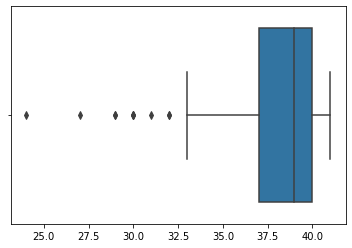

In [ ]:
# 인물별 사진 개수 확인
num_pics = [len(folder) for folder in list(idendities.values())]
import seaborn as sns
sns.boxplot(num_pics);

# Step1) idendities1~5

In [ ]:
# 사진 개수로 idendities dictionary를 sorting(내림차순)
folders = sorted(idendities, key=lambda x: len(idendities[x]), reverse=True)
idendities = {folder: idendities[folder] for folder in folders}

In [ ]:
idendities1, idendities2, idendities3, idendities4, idendities5 = {}, {}, {}, {}, {}

for i, (k, v) in enumerate(idendities.items()):
    if i % 5 == 0:
        idendities1[k] = v
    elif i % 5 == 1:
        idendities2[k] = v
    elif i % 5 == 2:
        idendities3[k] = v
    elif i % 5 == 3:
        idendities4[k] = v
    else:
        idendities5[k] = v

In [ ]:
print(len(idendities1), len(idendities2), len(idendities3), len(idendities4), len(idendities5))

64 64 64 64 64


In [ ]:
64*5

320

# step2 - (1) Positives1~5

Find different photos of same people

- idendities별로 1000쌍씩 뽑아서 positives1~5로 저장

In [ ]:
def extract_positive_df(idendities, n=1000, path='', random_state=1234):
    random.seed(random_state)
    # print(random.random())
    positives = []
    
    for key, values in idendities.items():

        #print(key)
        for i in range(0, len(values)-1):
            for j in range(i+1, len(values)):
                # print(key + '/' + values[i] + " and " + key + '/' + values[j])
                positive = []
                positive.append(key + '/' + values[i])
                positive.append(key + '/' + values[j])
                positives.append(positive)
    
    positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
    positives["decision"] = "Yes"
    positives = positives.sample(n=n).reset_index(drop=True)
    
    positives.file_x = path + positives.file_x
    positives.file_y = path + positives.file_y
    
    return positives

In [ ]:
positives1 = extract_positive_df(idendities1, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
positives2 = extract_positive_df(idendities2, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
positives3 = extract_positive_df(idendities3, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
positives4 = extract_positive_df(idendities4, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
positives5 = extract_positive_df(idendities5, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')

In [ ]:
print(positives1.shape, positives2.shape, positives3.shape, positives4.shape, positives5.shape)

(1000, 3) (1000, 3) (1000, 3) (1000, 3) (1000, 3)


In [ ]:
positives1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
...,...,...,...
995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes


# step2 - (2) Negatives1~5

Compare photos of different people

- idendities별로 1000쌍씩 뽑아서 negatives1~5로 저장


In [ ]:
def extract_negative_df(idendities, n=1000, path='', random_state=1234):
    random.seed(random_state)
    negatives = []
    
    samples_list = list(idendities.values())
    ids_keys_list = list(idendities.keys())
    for i in range(0, len(idendities) - 1):
        for j in range(i+1, len(idendities)):
            #print(samples_list[i], " vs ",samples_list[j]) 
            cross_product = itertools.product(samples_list[i], samples_list[j])
            cross_product = list(cross_product)
            #print(cross_product)

            for cross_sample in cross_product:
                # print(ids_keys_list[i] + '/' + cross_sample[0] + " vs " + ids_keys_list[j] + '/' + cross_sample[1])
                negative = []
                negative.append(ids_keys_list[i] + '/' + cross_sample[0])
                negative.append(ids_keys_list[j] + '/' + cross_sample[1])
                negatives.append(negative)
    
    negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
    negatives["decision"] = "No"
    negatives = negatives.sample(n=n).reset_index(drop=True)
    
    negatives.file_x = path + negatives.file_x
    negatives.file_y = path + negatives.file_y
    
    return negatives

In [ ]:
%%time
negatives1 = extract_negative_df(idendities1, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
negatives2 = extract_negative_df(idendities2, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
negatives3 = extract_negative_df(idendities3, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
negatives4 = extract_negative_df(idendities4, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')
negatives5 = extract_negative_df(idendities5, path='/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/')

CPU times: user 23.5 s, sys: 1.98 s, total: 25.4 s
Wall time: 25.4 s


In [ ]:
print(negatives1.shape, negatives2.shape, negatives3.shape, negatives4.shape, negatives5.shape)

(1000, 3) (1000, 3) (1000, 3) (1000, 3) (1000, 3)


In [ ]:
negatives1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
...,...,...,...
995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No


# step3) Merge Positives and Negative Samples

- positives + negatives = df1~5 생성

In [ ]:
df1 = pd.concat([positives1, negatives1]).reset_index(drop = True)
df2 = pd.concat([positives2, negatives2]).reset_index(drop = True)
df3 = pd.concat([positives3, negatives3]).reset_index(drop = True)
df4 = pd.concat([positives4, negatives4]).reset_index(drop = True)
df5 = pd.concat([positives5, negatives5]).reset_index(drop = True)

In [ ]:
df1.shape

(2000, 3)

In [ ]:
df1.decision.value_counts()

No     1000
Yes    1000
Name: decision, dtype: int64

In [ ]:
df1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
...,...,...,...
1995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
1996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
1997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
1998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No


In [ ]:
df1.iloc[0, 0]

'/content/drive/My Drive/기업프로젝트-라젠/data/40, 320 + cascade/10599708/1053712640,2994395027_align.jpg'

# DeepFace

In [ ]:
!pip install deepface
from deepface import DeepFace

In [ ]:
def add_dist_col(df, model='Facenet', distance_metric='euclidean_l2', col_name='dist_l2'):
    # euclidean l2 distance가 default 값
    
    instances = df[["file_x", "file_y"]].values.tolist()
    
    resp_obj = DeepFace.verify(instances, model_name = model, distance_metric = distance_metric, enforce_detection=False)
    
    distances = []
    for i in range(0, len(instances)):
        distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
        distances.append(distance)
        
    df[col_name] = distances
    
    return df

In [ ]:
%%time
# 코드가 안 돌아가면 재부팅하세요
df1 = add_dist_col(df1)
df2 = add_dist_col(df2)
df3 = add_dist_col(df3)
df4 = add_dist_col(df4)
df5 = add_dist_col(df5)

Using Facenet model backend euclidean_l2 distance.
facenet_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1971Xk5RwedbudGgTIrGAL4F7Aifu7id1
To: /root/.deepface/weights/facenet_weights.h5
92.2MB [00:00, 174MB/s]
Verification: 100%|██████████| 2000/2000 [23:26<00:00,  1.42it/s]


Using Facenet model backend euclidean_l2 distance.


Verification: 100%|██████████| 2000/2000 [23:11<00:00,  1.44it/s]


Using Facenet model backend euclidean_l2 distance.


Verification: 100%|██████████| 2000/2000 [22:55<00:00,  1.45it/s]


Using Facenet model backend euclidean_l2 distance.


Verification: 100%|██████████| 2000/2000 [23:26<00:00,  1.42it/s]


Using Facenet model backend euclidean_l2 distance.


Verification: 100%|██████████| 2000/2000 [23:26<00:00,  1.42it/s]

CPU times: user 55min 36s, sys: 1min 42s, total: 57min 19s
Wall time: 1h 56min 54s


In [ ]:
# decision -> y : labeling
encoder = LabelEncoder()
encoder.fit(df1['decision'])
df1['y'] = encoder.transform(df1['decision']) # 1='Yes'/0='No'
df2['y'] = encoder.transform(df2['decision'])
df3['y'] = encoder.transform(df3['decision'])
df4['y'] = encoder.transform(df4['decision'])
df5['y'] = encoder.transform(df5['decision'])

In [ ]:
df1

,file_x,file_y,decision,dist_l2,y
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.2868,1
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.6647,1
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.7705,1
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.7751,1
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.8217,1
...,...,...,...,...,...
1995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.4533,0
1996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.3256,0
1997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2328,0
1998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2837,0


In [ ]:
# df1.to_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/df1_lfw.csv', index=False)
# df2.to_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/df2_lfw.csv', index=False)
# df3.to_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/df3_lfw.csv', index=False)
# df4.to_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/df4_lfw.csv', index=False)
# df5.to_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/df5_lfw.csv', index=False)

# 5-folds accuracy & threshold

- `DecisionTreeClassifier`를 사용해서 threshold 구하기
- 4 sets로 threshold 구하고 -> 1 set으로 아래의 지표값 구하기
    - confusion matrix
    - precision / recall / f1-score / accuracy 

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz

In [ ]:
def get_thresholds_and_accuracy(all_df_list, X_col='dist_l2'):
    
    thresholds, precision, recall, f1, accuracy = [], [], [], [], []
    
    for i in range(len(all_df_list)):
        train = pd.concat([df for j, df in enumerate(all_df) if j != i]).reset_index(drop=True)
        test = all_df[i]
        
        #-------------------------------------------
        clf = DecisionTreeClassifier(max_depth=1)
        X_train = train[X_col].values.reshape(-1, 1)
        y_train = train['y'].values.reshape(-1, 1)
        clf.fit(X_train, y_train)
        
        threshold = clf.tree_.threshold[0]
        thresholds.append(threshold)
        
        #-------------------------------------------
        X_test = test['dist_l2'].values.reshape(-1, 1)
        y_test = test['y'].values.reshape(-1, 1)
        y_test_pred = clf.predict(X_test)
        
        test['y_pred'] = "No"
        idx = test[test.dist_l2 <= threshold].index
        test.loc[idx, 'y_pred'] = 'Yes'
        
        cm = confusion_matrix(test.decision.values, test.y_pred.values)
        tn, fp, fn, tp = cm.ravel()
        
        precision_val = tp / (tp + fp)
        recall_val = tp / (tp + fn)
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)
        accuracy_val = (tp + tn)/(tn + fp +  fn + tp)
        
        precision.append(precision_val)
        recall.append(recall_val)
        f1.append(f1_val)
        accuracy.append(accuracy_val)
        
        
    return thresholds, precision, recall, f1, accuracy

In [ ]:
all_df = [df1, df2, df3, df4, df5]
thresholds, precision, recall, f1, accuracy = get_thresholds_and_accuracy(all_df)

In [ ]:
final_threshold = np.mean(thresholds) # threshold 
print('final threshold (cropped Asian): {}'.format(final_threshold))

final threshold (cropped Asian): 1.0501000046730042


In [ ]:
acc_mean, acc_std = np.mean(accuracy), np.std(accuracy)
print('accuracy (cropped Asian): {:.2f}±{:.2f} %'.format(acc_mean*100, acc_std*100))

accuracy (cropped Asian): 70.59±0.56 %


★★★ threshold for facenet (10000 cropped_data) = 1.0501000046730042 ★★★

# ROC curve

In [ ]:
df = pd.concat(all_df, axis=0).reset_index(drop=True)
df['y_pred_final'] = "No"
idx = df[df.dist_l2 <= final_threshold].index
df.loc[idx, 'y_pred'] = 'Yes'

In [ ]:
df['dist_l2_scaled'] = -df['dist_l2']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df['decision'])
df_label_encoded = encoder.transform(df['decision']) # 1='Yes' / 0='No'
df_label_encoded

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
fpr, tpr, thresholds = roc_curve(df_label_encoded, df['dist_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

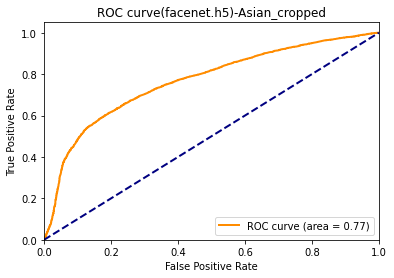

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(facenet.h5)-Asian_cropped')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df

,file_x,file_y,decision,dist_l2,y,y_pred,y_pred_final,dist_l2_scaled
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.2868,1,No,No,-1.2868
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.6647,1,Yes,No,-0.6647
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.7705,1,Yes,No,-0.7705
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.7751,1,Yes,No,-0.7751
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.8217,1,Yes,No,-0.8217
...,...,...,...,...,...,...,...,...
9995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2732,0,No,No,-1.2732
9996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2469,0,No,No,-1.2469
9997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2199,0,No,No,-1.2199
9998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.1270,0,No,No,-1.1270


In [ ]:
# df.to_csv("/content/drive/My Drive/main_proj/라젠/deepface/tests/outputs/threshold_pivot_Asian_cropped_10000.csv", index = False)